# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## BHAGYASHREE KESWANI
## STUDENT ID: 1006790849

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1xK8ZLyIjKq5WgxGwnjb_eveSFGPv-cEk?usp=sharing

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [15]:
!pip install torchtext==0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [17]:
f = open('SMSSpamCollection')
labels=[]
msgs=[]
for data in f:
  labels.append(data.split('\t',2)[0])
  msgs.append(data.split('\t',2)[1])

ham_msgs,spam_msgs=[],[]
for i in range(len(labels)):
  if 'ham' in labels[i]:
    ham_msgs.append(msgs[i])
  else:
    spam_msgs.append(msgs[i])
print('Spam label:', np.unique(labels)[1])
print('Spam message:',spam_msgs[0])

print('Non-Spam label:', np.unique(labels)[0])
print('Non-Spam message:',ham_msgs[0])

Spam label: spam
Spam message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-Spam label: ham
Non-Spam message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [18]:
print("Number of spam messages in the data set:",len(spam_msgs))
print("Number of non-spam messages in the data set:",len(ham_msgs))

Number of spam messages in the data set: 747
Number of non-spam messages in the data set: 4827


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages of character level RNN:**

- The vocabulary for character-level RNN is relatively much smaller than word sequences which has to store all words in the dataset. The entire English vocabularu consists of thousands of words whereas number of characters is just 97. Thus, character-level RNN implies small size of encoding and lower memory space requirement.

- When word encoding is used, the model is not able to learn unusual words and treats it as 'unknown' text. In character-level RNN, the models are trained on characters which helps predicting new text unavailable in the vocabulary.

- Character RNN do not require tokenization and are free from grammatical/spelling mistakes. However, spelling errors may significantly impact word-based RNN performance due to change in sentence meaning.

- Character-level RNN work especially better with certain languages having complex morphology like Russian, Turkish etc which ar every difficult to be modelled using word sequences.


**Disadvantages of character level RNN:**

- The character-level models require higher number of hidden layers and take longer time to train as they need to learn spelling, syntax, semantics etc whereas word-based RNN train faster. The complex architecture may lead to vanishing gradients dropping the model performance.

- The number of elements in a character sequence is equal to the total number of characters in the sentence whereas for words, it is the total number of words in the sentence. Thus, the number of predictions required in the former is more making the result more erroreneous.

- Some words that lead to high error may have a substantial representation in the sequence as they are modelled in the form of characters. This may result in message being misclassified as spam/ non-spam.

- Character RNN is not good at capturing long distance dependencies. To predict the third word in the sequence, it has to go through all the characters in first and second words. 


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [19]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

dataset[0].sms
dataset[0].label
train, valid, test = dataset.split([0.60, 0.20, 0.20])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

**Answer:**
- There is high chance that a classifier may show bias towards the class with larger number of samples. The model may have a high accuracy for the majority class but may have a pooor performance on the class with insufficient samples. This will not reflect the actual performance of the model as it may have a high overall accuracy but a very poor recall/precision.

- In our dataset, there are fewer spam messages than non-spam messages. If the data is not balanced, the model may just learn to predict spam messages and may even predict spam as non-spam messages. 

In [20]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

**Answer:**

text_field.vocab.stoi: A dictionary mapping the token strings to a numerical identifier.

text_field.vocab.itos: A list of token strings indexed by their numerical indentifier


In [21]:
text_field.build_vocab(train)
print("stoi: ", text_field.vocab.stoi)
print("itos: ", text_field.vocab.itos)

stoi:  defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f7290107b90>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, '4': 36, 'I': 37, '3': 38, '7': 39, 'x': 40, 'N': 41, '6': 42, 'A': 43, '!': 44, 'R': 45, ',': 46, '9': 47, 'P': 48, 'M': 49, 'U': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, 'G': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'V': 66, 'z': 67, 'X': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ')': 73, ';': 74, '+': 75, 'q': 76, '"': 77, '#': 78, '(': 79, 'Q': 80, '@': 81, '=': 82, 'Z': 83, 'ü': 84, '>': 85, 'Ü': 86, '$': 87, '\x92': 88, '‘': 89, '[': 90, ']': 91, '<': 92, '%': 93, '|': 94, '_': 95, '\x93': 96, '“': 97, '

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer:**

**unk**: an "unknown token" representing an unkown character in train vocabulary.

**pad**: character 1  appended to the texts to have same length messages in a given batch.



### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [22]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

**Printing out the length of each batch, maximum length of the input sequence in each batch and number of pad tokens in first 10 batches:**

In [24]:
for i,batch in enumerate(train_iter):
    if i<10:
      print("Batch ", i)
      print('Length of the batch:',len(batch))
      print("Max length of the input sequence:",(batch.sms[1]).max().item())
      print('Number of pad tokens:',(batch.sms[0]==1).sum().item())
      print('-------------------------------------------------------')      
    else:
      break

Batch  0
Length of the batch: 32
Max length of the input sequence: 156
Number of pad tokens: 14
-------------------------------------------------------
Batch  1
Length of the batch: 32
Max length of the input sequence: 158
Number of pad tokens: 0
-------------------------------------------------------
Batch  2
Length of the batch: 32
Max length of the input sequence: 41
Number of pad tokens: 20
-------------------------------------------------------
Batch  3
Length of the batch: 32
Max length of the input sequence: 154
Number of pad tokens: 0
-------------------------------------------------------
Batch  4
Length of the batch: 32
Max length of the input sequence: 43
Number of pad tokens: 40
-------------------------------------------------------
Batch  5
Length of the batch: 32
Max length of the input sequence: 154
Number of pad tokens: 21
-------------------------------------------------------
Batch  6
Length of the batch: 32
Max length of the input sequence: 139
Number of pad tokens:

## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [25]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [26]:
class msgLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, type_model = 1):
    super(msgLSTM, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2)
    self.type_model = type_model
    self.name = 'RNN_m{}_h{}'.format(type_model, hidden_size)

  def forward(self, x):
    # Look up the embedding
    x = self.emb[x]
    # Set an initial hidden state and cell state
    h0= torch.zeros(1, x.size(0), self.hidden_size)
    c0= torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the LSTM
    out, _ = self.rnn(x, (h0, c0))

    if self.type_model == 1:
      out = self.fc(out[:,-1,:])

    if self.type_model == 2:
      out = self.fc(torch.max(out, dim=1)[0])
      
    if self.type_model == 3:
      out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
    
    return out

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [27]:
def get_accuracy(model, data_loader, criterion):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct, total, total_loss, n = 0, 0, 0, 0
    for data in data_loader:

      output=model(data.sms[0])
      pred = output.max(1, keepdim=True)[1]

      correct += pred.eq(data.label.view_as(pred)).sum().item()
      total += data.label.shape[0]
      loss = criterion(output, data.label)
      total_loss += loss.item()
      n+=1

    accuracy= float(correct/total)
    loss=float(total_loss) / (n+1)

    return accuracy,loss

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [28]:
def train_network(model, batch_size = 32, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss=np.zeros(num_epochs)
    valid_loss=np.zeros(num_epochs)
    train_acc=np.zeros(num_epochs)
    valid_acc = np.zeros(num_epochs)
    epochs = []
    n=0

    train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    
    for epoch in range(num_epochs):
      for data in train_iter:
        
        optimizer.zero_grad()
        pred = model(data.sms[0])
        loss = criterion(pred, data.label)
        loss.backward()
        optimizer.step()
            
      epochs.append(epoch)
      train_acc[epoch],train_loss[epoch] = get_accuracy(model, train_iter,criterion=criterion)
      valid_acc[epoch],valid_loss[epoch] = get_accuracy(model,valid_iter,criterion = criterion)
      
      print(("Epoch : {}/{} , Train accuracy: {} ,Validation accuracy: {}, \
      || Train loss: {} , Validation loss: {}")\
      .format(epoch+1, num_epochs,train_acc[epoch], valid_acc[epoch],\
              train_loss[epoch],valid_loss[epoch]))
      
      print(("").format())

      # Save the model(checkpoint) to a file in google drive
      model_path = "{}_epoch_{}".format(model.name,epoch+1)
      torch.save(model.state_dict(), model_path)

                                                                                                                        
    # plotting

    plt.title("Training/Validation Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training/Validation Loss Curve")
    plt.plot(epochs,train_loss, label="Train")
    plt.plot(epochs,valid_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1])) 

Epoch : 1/10 , Train accuracy: 0.7691397667737029 ,Validation accuracy: 0.8493273542600897,       || Train loss: 0.6686321934486957 , Validation loss: 0.6382988346250433

Epoch : 2/10 , Train accuracy: 0.8947101571742437 ,Validation accuracy: 0.9506726457399103,       || Train loss: 0.3900710821468779 , Validation loss: 0.33015973003287064

Epoch : 3/10 , Train accuracy: 0.9083995267872232 ,Validation accuracy: 0.9533632286995516,       || Train loss: 0.2647466680153887 , Validation loss: 0.22015583672021566

Epoch : 4/10 , Train accuracy: 0.9190468142639852 ,Validation accuracy: 0.9596412556053812,       || Train loss: 0.2383748144307669 , Validation loss: 0.20261064171791077

Epoch : 5/10 , Train accuracy: 0.9386513435862768 ,Validation accuracy: 0.9560538116591928,       || Train loss: 0.21369061202920497 , Validation loss: 0.19965052761529622

Epoch : 6/10 , Train accuracy: 0.9310461382457327 ,Validation accuracy: 0.9695067264573991,       || Train loss: 0.20708619004630663 , Valid

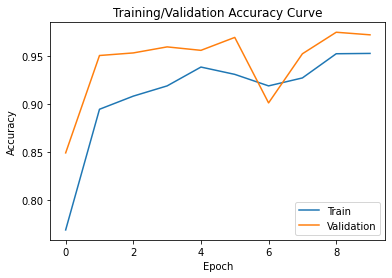

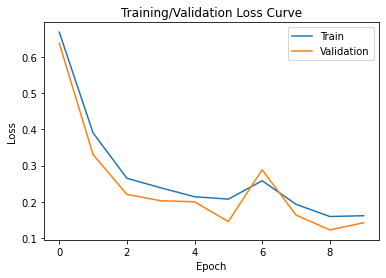

Final Training Accuracy: 0.952847726888626
Final Validation Accuracy: 0.9721973094170404


In [ ]:
model = msgLSTM(input_size = len(text_field.vocab),hidden_size = 20,type_model=1)
train_network(model,  batch_size = 64,num_epochs=10, learning_rate=1e-3)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Answer:**

The hyperparameters selected for tuning are:

- **Type of model**: As advised in the handout, different methods are used to generate outputs from the networks. First type uses RNN output value for final token. Second one max-pools over the entire output array while third one concatenates the max-pooling and average-pooling of RNN outputs.

- **Hidden size**: As the hidden size is increased, the complexity of the NN increases and enables it to extract more useful features. However, too complex models can lead to overfitting. So, this hyperparameter needs careful tuning.

- **Learning Rate**: It determines how quickly the model is adapted to the data. Smaller learning rates make smaller weight updates and take longer to converge while larger rates converge faster making large weight updates. However, too high learning rate may make the model unstable and it may fail to converge to global minimum. Hence, tuning this hyperparameter is important

- **Batch size**: Appropriate batch size with appropriate learning rate is essential for good performance. Higher batch sizes allow for higher learning rate whereas smaller batch sizes are stable with lower learning rates.









**How I tuned the hyperparameters:**

At first, I increased the hidden size from 20 to 50 in model 1 to see if increasing complexity of the model improves the performance:

**Model 1 results:**
- Final Training Accuracy: 0.9260674530652933
- Final Validation Accuracy: 0.9847533632286996

The validation accuracy seems to have increased by 1% meaning that the model is now able to learn more features. I am now increasing the batch size from 32 to 64 in model 2 to see if it results in better learning:

**Model 2 results:**
- Final Training Accuracy: 0.9371988702442267
- Final Validation Accuracy: 0.9856502242152466

The validation accuracy increased by 0.001% which means that model is performing slightly better after increasing batch size. I am now increasing the learning rate from 0.001 to 0.002 in model 3 as higher batch size allow for higher learning rates

**Model 3 results:**
- Final Training Accuracy: 0.9395248380129589
- Final Validation Accuracy: 0.9820627802690582

The validation accuracy is almost same so I now change the model type from 1 to 2 in model 4.

**Model 4 results:**
- Final Training Accuracy: 0.9792324306363184
- Final Validation Accuracy: 0.9856502242152466

The validation accuracy has improved indicating that model type 2 performs better. I now change model type to 3 in model 5 to see if there is any change in performance.

**Model 5 results:**
- Final Training Accuracy: 0.4790868188635227
- Final Validation Accuracy: 0.8475336322869955

The accuracies have reduced significantly meaning that this setting is not ideal.



After performing multiple iterations for different values of the hyperparameters listed above, the best validation accuracy obtained was 98.565% in **Model 4**. The corresponding training accuracy was 97.923%. 

The best model is summarised as follows:

- hidden_size=50
- model type=2
- Batch size=64
- Number of epochs=10
- Learning rate=0.002

Epoch : 1/10 , Train accuracy: 0.8770559893670045 ,Validation accuracy: 0.9497757847533632,       || Train loss: 0.40669576392361995 , Validation loss: 0.31419317631257904

Epoch : 2/10 , Train accuracy: 0.9244060475161987 ,Validation accuracy: 0.9820627802690582,       || Train loss: 0.23226973226195888 , Validation loss: 0.1925538383010361

Epoch : 3/10 , Train accuracy: 0.9277288586143878 ,Validation accuracy: 0.9721973094170404,       || Train loss: 0.2168734754288667 , Validation loss: 0.145137637336221

Epoch : 4/10 , Train accuracy: 0.9189234092041867 ,Validation accuracy: 0.9829596412556054,       || Train loss: 0.20626367692296443 , Validation loss: 0.10537016277925836

Epoch : 5/10 , Train accuracy: 0.9174281442100016 ,Validation accuracy: 0.9829596412556054,       || Train loss: 0.2079516747574273 , Validation loss: 0.1385948339270221

Epoch : 6/10 , Train accuracy: 0.9456720385446087 ,Validation accuracy: 0.967713004484305,       || Train loss: 0.21207935639755113 , Validat

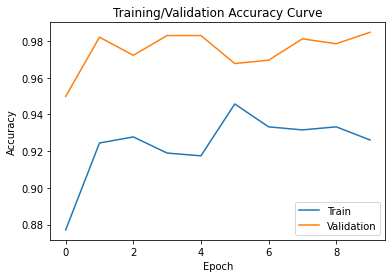

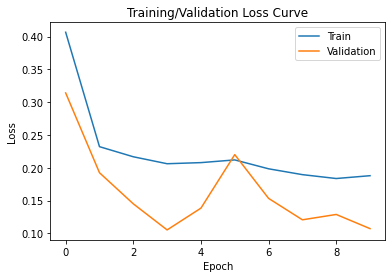

Final Training Accuracy: 0.9260674530652933
Final Validation Accuracy: 0.9847533632286996


In [ ]:
#changing hidden size to 50
model_1 = msgLSTM(input_size = len(text_field.vocab),hidden_size = 50,type_model=1)
train_network(model_1,  batch_size = 32,num_epochs=10, learning_rate=1e-3)

Epoch : 1/10 , Train accuracy: 0.8700780860608075 ,Validation accuracy: 0.8780269058295964,       || Train loss: 0.5157845159992576 , Validation loss: 0.5471113167311016

Epoch : 2/10 , Train accuracy: 0.91792656587473 ,Validation accuracy: 0.9632286995515695,       || Train loss: 0.250744347111322 , Validation loss: 0.2277485108689258

Epoch : 3/10 , Train accuracy: 0.7785346403056986 ,Validation accuracy: 0.9031390134529148,       || Train loss: 0.4753619270243992 , Validation loss: 0.28940287389253316

Epoch : 4/10 , Train accuracy: 0.9230769230769231 ,Validation accuracy: 0.9668161434977578,       || Train loss: 0.21527441705499464 , Validation loss: 0.16886353257455325

Epoch : 5/10 , Train accuracy: 0.9290579830536634 ,Validation accuracy: 0.979372197309417,       || Train loss: 0.18339916764913747 , Validation loss: 0.10630084182086744

Epoch : 6/10 , Train accuracy: 0.941020103007144 ,Validation accuracy: 0.9811659192825112,       || Train loss: 0.1754090155203206 , Validation 

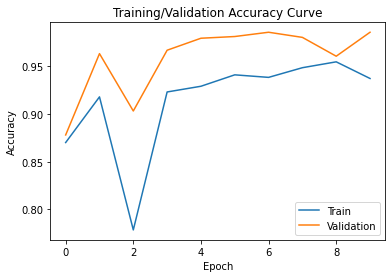

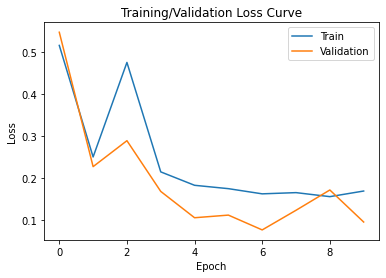

Final Training Accuracy: 0.9371988702442267
Final Validation Accuracy: 0.9856502242152466


In [ ]:
#changing batch size to 64 keeping hidden size=50
model_2 = msgLSTM(input_size = len(text_field.vocab),hidden_size = 50,type_model=1)
train_network(model_2,  batch_size = 64,num_epochs=10, learning_rate=1e-3)

Epoch : 1/10 , Train accuracy: 0.9310516697125768 ,Validation accuracy: 0.9345291479820628,       || Train loss: 0.34415163891389966 , Validation loss: 0.5006782757608514

Epoch : 2/10 , Train accuracy: 0.9312178102674863 ,Validation accuracy: 0.967713004484305,       || Train loss: 0.22493897044720748 , Validation loss: 0.18602637593683444

Epoch : 3/10 , Train accuracy: 0.9367004485794983 ,Validation accuracy: 0.979372197309417,       || Train loss: 0.19705788820283487 , Validation loss: 0.1168892844335029

Epoch : 4/10 , Train accuracy: 0.9425153680013292 ,Validation accuracy: 0.9730941704035875,       || Train loss: 0.18313020986776488 , Validation loss: 0.14274184876366666

Epoch : 5/10 , Train accuracy: 0.9440106329955142 ,Validation accuracy: 0.9802690582959641,       || Train loss: 0.17406333199081322 , Validation loss: 0.10906868506419032

Epoch : 6/10 , Train accuracy: 0.9385279946835022 ,Validation accuracy: 0.9811659192825112,       || Train loss: 0.18308584096181826 , Vali

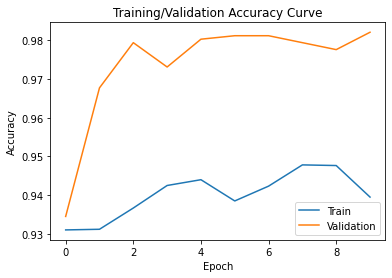

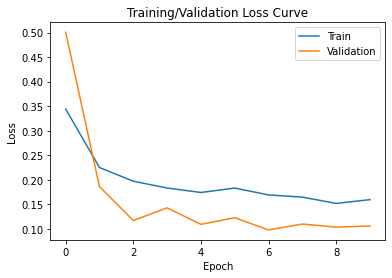

Final Training Accuracy: 0.9395248380129589
Final Validation Accuracy: 0.9820627802690582


In [ ]:
#changing learning rate=0.002 keeping hidden size= 50 and batch size= 64
model_3 = msgLSTM(input_size = len(text_field.vocab),hidden_size = 50,type_model=1)
train_network(model_3,  batch_size = 64,num_epochs=10, learning_rate=0.002)

Epoch : 1/10 , Train accuracy: 0.9282272802791162 ,Validation accuracy: 0.97847533632287,       || Train loss: 0.30583842494525015 , Validation loss: 0.3956476810731386

Epoch : 2/10 , Train accuracy: 0.9474995846486127 ,Validation accuracy: 0.9641255605381166,       || Train loss: 0.19230648178684837 , Validation loss: 0.22743102437571475

Epoch : 3/10 , Train accuracy: 0.9425153680013292 ,Validation accuracy: 0.9775784753363229,       || Train loss: 0.17506170754010478 , Validation loss: 0.1617504373977059

Epoch : 4/10 , Train accuracy: 0.9466688818740655 ,Validation accuracy: 0.97847533632287,       || Train loss: 0.1479856215931553 , Validation loss: 0.11153856919784295

Epoch : 5/10 , Train accuracy: 0.9511546768566207 ,Validation accuracy: 0.9775784753363229,       || Train loss: 0.12635727196660204 , Validation loss: 0.09256339426103391

Epoch : 6/10 , Train accuracy: 0.9614553912610068 ,Validation accuracy: 0.9811659192825112,       || Train loss: 0.10983434135171895 , Validat

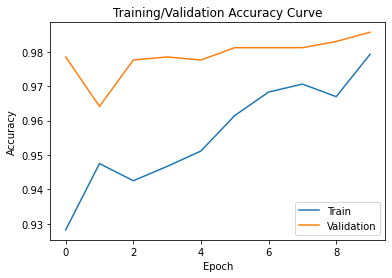

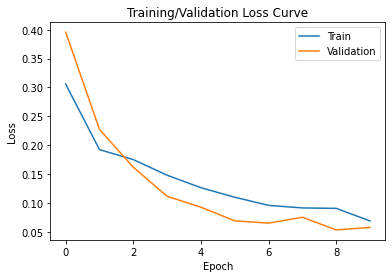

Final Training Accuracy: 0.9792324306363184
Final Validation Accuracy: 0.9856502242152466


In [ ]:
#changing model type to 2
model_4 = msgLSTM(input_size = len(text_field.vocab),hidden_size = 50,type_model=2)
train_network(model_4,  batch_size = 64,num_epochs=10, learning_rate=0.002)

Epoch : 1/10 , Train accuracy: 0.5167472087985335 ,Validation accuracy: 0.13901345291479822,       || Train loss: 3.3609038528643156 , Validation loss: 3.22133815915961

Epoch : 2/10 , Train accuracy: 0.5444092651224796 ,Validation accuracy: 0.20269058295964126,       || Train loss: 3.2039722969657496 , Validation loss: 3.067739147888987

Epoch : 3/10 , Train accuracy: 0.5167472087985335 ,Validation accuracy: 0.13901345291479822,       || Train loss: 3.112093616786756 , Validation loss: 2.9786428401344702

Epoch : 4/10 , Train accuracy: 0.7420429928345276 ,Validation accuracy: 0.5650224215246636,       || Train loss: 3.046396413602327 , Validation loss: 2.914857211865877

Epoch : 5/10 , Train accuracy: 0.8390268288618563 ,Validation accuracy: 0.8116591928251121,       || Train loss: 2.9986877868050024 , Validation loss: 2.865619333166825

Epoch : 6/10 , Train accuracy: 0.47592067988668557 ,Validation accuracy: 0.8385650224215246,       || Train loss: 2.969567810861688 , Validation loss

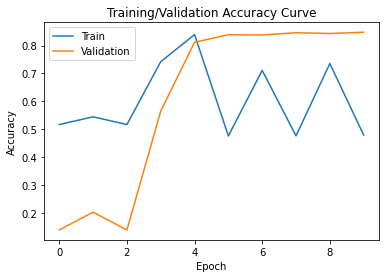

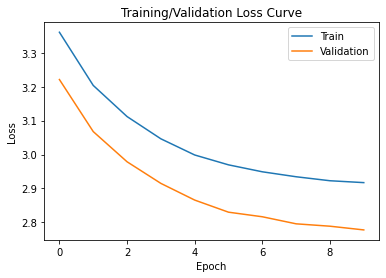

Final Training Accuracy: 0.4790868188635227
Final Validation Accuracy: 0.8475336322869955


In [ ]:
#changing model type to 3
model_5 = msgLSTM(input_size = len(text_field.vocab),hidden_size = 50,type_model=3)
train_network(model_5,  batch_size = 64,num_epochs=10, learning_rate=0.002)

**Loading the best model below:**

In [30]:
best_model = msgLSTM(input_size = len(text_field.vocab),hidden_size = 50, \
                     type_model = 2)
model_path = '/content/RNN_m2_h50_epoch_10'
state = torch.load('RNN_m2_h50_epoch_10')
best_model.load_state_dict(state)

<All keys matched successfully>

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [31]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [32]:
spam_valid_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False) 

nospam_valid_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

spam_acc, spam_loss = get_accuracy(best_model, spam_valid_iter, criterion=nn.CrossEntropyLoss())
nospam_acc, nospam_loss = get_accuracy(best_model, nospam_valid_iter, criterion=nn.CrossEntropyLoss())

false_neg_rate= 1-spam_acc
false_pos_rate= 1-nospam_acc

print('False negative rate for validation data:',false_neg_rate)
print('False positive rate for validation data:',false_pos_rate)

False negative rate for validation data: 0.06896551724137934
False positive rate for validation data: 0.03402061855670102


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

- False positive and false negative rates are important metrics to assess spam detection model. They can help protect users from fraud and other risks and instead pay attention to genuine messages.
- A false positive means that non-spam messages are flagged as spam and are not received by the user. This would result in user losing important information related to payment, meetings etc. Missing important information could have severe repurcussions for doctors, government officials and other people in critical professions.
- A false negative means that the model failed to detect spam messages and the user received them in his inbox. There are chances that the user could be scammed and may have his personal details leaked. Also, it is stressful for the user to deal with too many spam notifications which he has to delete from his inbox everytime.


## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [33]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False) 

test_accuracy, test_loss = get_accuracy(best_model, test_iter, criterion=nn.CrossEntropyLoss())
print('Final Test Accuracy for best model:',test_accuracy)

Final Test Accuracy for best model: 0.9515260323159784


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [34]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

spam_test_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

nospam_test_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

spam_acc_test, spam_loss_test = get_accuracy(best_model, spam_test_iter, criterion=nn.CrossEntropyLoss())
nospam_acc_test, nospam_loss_test = get_accuracy(best_model, nospam_test_iter, criterion=nn.CrossEntropyLoss())

false_neg_rate_test= 1-spam_acc_test
false_pos_rate_test= 1-nospam_acc_test

print('False negative rate for test data:',false_neg_rate_test)
print('False positive rate for test data:',false_pos_rate_test)

False negative rate for test data: 0.07333333333333336
False positive rate for test data: 0.0456431535269709


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [37]:
msg = "machine learning is sooo cool!"
ch_tokens = []

for character in msg:
  ch_tokens.append(torch.tensor(text_field.vocab.stoi[character]))

all_tokens = torch.LongTensor([ch_tokens])

prediction = best_model(all_tokens)
prob = F.softmax(prediction, dim=1)
prob_precent=round(float(prob[0][1]*100),5)
print('Probability that the SMS is spam:',prob_precent,'%')

Probability that the SMS is spam: 6.47826 %


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer:**

There are several algorithms that can be used to detect spam and although they may not have a very low false positive and flase negative rate, they are easy to build and give moderate performance. Spam messages is a widespread problem and one of the most common tasks in Natural Language Processing. There is extensive research conducted in this field by top-tech giants resulting in some advanced spam blocking engines that have really good performance. Therefore, at this point, spam detection is an easy task as compared to other state-of-the-art topics like text/image generation, speech recognition etc which need complex DL techniques for decent performance. 

Various popular classification algorithms like Naive Bayes, SVM and Multi-Layer Percepton(MLP) can be used for this. The steps for building a Naive Bayes(supervised learning) can be summarised as follows:
- The SMS are vectorised and split into train and test sets
- The Naive Bayes classifier model is defined using the library available in sklearn.
- The model is then fit on the train data and learns the joint probability distributions for the train data.
- The model then make predictions on test data.

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
!pip install fastai==1.0.61

In [1]:
!pip install -U spacy==2.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [3]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-11-21 00:20:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.4’

smsspamcollection.z 100%[===================>] 198.65K   304KB/s    in 0.7s    

2022-11-21 00:20:20 (304 KB/s) - ‘smsspamcollection.zip.4’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This time we will load the data using pandas.

In [4]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [6]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [7]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [8]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when a bat is dropped by another character in a series
The problem usually starts when someone or someone runs out of food or leaves the
The problem usually starts when a question line or one is fill , because the
The problem usually starts when an escape cafe is set clean , but then change
The problem usually starts when there is no time for doing so , as there


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

In [9]:
for i in range(5):
  print(lang_mod.predict("The student did well because", n_words=10))

The student did well because the East Bank in London , where
The student did well because of its children 's connection to age and alive .
The student did well because of its simple " - place " name , which
The student did well because they saw God billion , but two small numbers
The student did well because of the center 's weight , and the use of


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [10]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.582067,3.898833,0.271429,00:02
1,4.854765,3.959996,0.271429,00:02
2,4.396543,3.841180,0.257143,00:02
3,4.069307,3.855830,0.271429,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.573458,3.779907,0.271429,00:02
1,3.534193,3.707488,0.257143,00:02
2,3.487144,3.696584,0.257143,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.383816,3.694176,0.271429,00:02
1,3.368413,3.685179,0.257143,00:02
2,3.353456,3.682620,0.257143,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.323679,3.697419,0.257143,00:04
1,3.288547,3.675353,0.285714,00:04
2,3.253368,3.664379,0.285714,00:04


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [11]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
data_clas.show_batch()

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
xxbos xxmaj for me the love should start with xxunk should feel that i need her every time around xxunk should be the first thing which comes in my thoughts . i would start the day and end it with xxunk should be there every time i xxunk will be then when my every breath has her xxunk life should happen around xxunk life will be named to her .,ham
"xxbos < # > is fast xxunk . xxmaj so , xxmaj wish u a very xxmaj happy xxmaj new xxmaj year xxmaj happy xxmaj xxunk xxmaj happy xxunk day xxmaj happy xxmaj valentines xxmaj day xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk day xxmaj happy xxmaj may xxmaj day xxmaj happy xxmaj xxunk xxmaj day , xxmaj happy xxmaj friendship , xxmaj mother ,",ham
"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < xxup decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : xxmaj sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - xxmaj maid",ham


In [13]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [14]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 2.51E-02


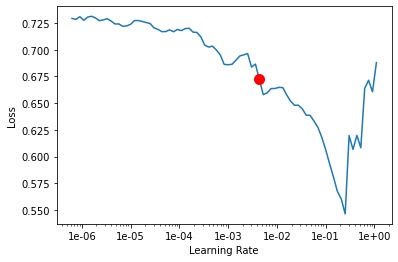

In [15]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [16]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.384117,0.071050,0.979665,00:04
1,0.188848,0.068091,0.984450,00:03
2,0.135457,0.062917,0.983254,00:03
3,0.095456,0.063706,0.988038,00:03
4,0.099666,0.064934,0.988636,00:03


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

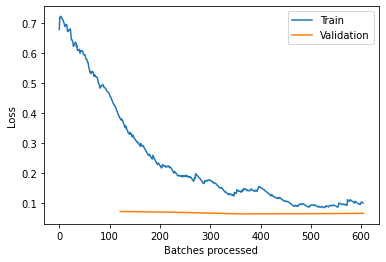

In [17]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-02


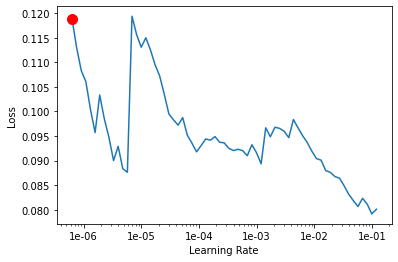

In [18]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [19]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9980e-01, 2.0450e-04]))

In [20]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.2627, 0.7373]))

Next we will evaluate on all of our validation data.

In [51]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

**Answer:**

The accuracy obtained with ULMFit model is 98.86% whereas with LSTM, we obtained a test accuracy of 95.06% and validation accuracy of 98.565%.

Transfer learning with ULMFit requires lesser data/resources to train and gives better performance because it is pretained with large amount of wikipedia text already.

In [54]:
pred_ulmfit = valid_preds.max(1, keepdim=True)[1]
correct_pred_ulmfit = pred_ulmfit.eq(valid_label.view_as(pred_ulmfit)).sum().item()
total_pred_ulmfit = len(valid_label)

ulmfit_acc= float(correct_pred_ulmfit/total_pred_ulmfit)
print('Validation Accuracy of ULMFiT model:', round(float(ulmfit_acc),5)*100,'%')

Validation Accuracy of ULMFiT model: 98.86399999999999 %


### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?


**Answer:**

For LSTM model, we calculated both test and validation accuracies as it was split into 3 sets: train, validation and test. However, for ULMFiT, we evaluate only based on validation accuracy. The confusion matrices for the two models can be summarised as follows:

- ULMFiT model has higher false negatives whereas LSTM has higher false positives. ULMFiT has just 2 flase positives whereas LSTM has 46 meaning LSTM is flagging  a lot of regular messages as spam. ULMFiT fails to detect 17 spam messages whereas LSTM fails to detect 9; however this dooes not mean that LSTM detects spam messages better as its evaluation data is smaller than ULMFiT.

- The total number of false negatives and false positives are 19 for ULMFiT and 55 for LSTM. Although ULMFiT has more evaluation data, it still gives fewer false predictions which means that the its performance is better than LSTM in terms of confusion matrix.



**Confusion matrix for ULMFit Model:**

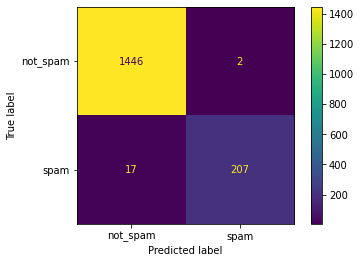

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(valid_label, pred_ulmfit)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_spam','spam'])
cmd.plot()

**Confusion matrix for best LSTM Model:**

In [82]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False) 

Test Accuracy of best LSTM model : 95.063 %


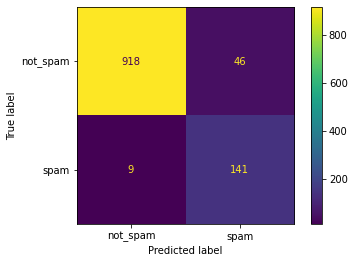

In [88]:
correct,total=0,0
pred_rnn = []
label_rnn= []

for data in test_iter:
  output=best_model(data.sms[0])
  pred = output.max(1, keepdim=True)[1]
  pred_rnn.extend(pred.squeeze())
  label_rnn.extend(data.label)

  correct += pred.eq(data.label.view_as(pred)).sum().item()
  total += data.label.shape[0]

cm = confusion_matrix(label_rnn, pred_rnn)#, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_spam','spam'])
cmd.plot()

print('Test Accuracy of best LSTM model :',round(float(correct/total),5)*100,'%')

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [29]:
def test_models_umlfit(msg,testing_spam=True):
  prob=learn_classifier.predict(msg)[2][1]
  if testing_spam:
    print(f'ULMFiT Probability that it is spam: {prob:.3f}')
  else:
    print(f'ULMFiT Probability that it is not spam: {1-prob:.3f}')


def test_models_lstm(msg,testing_spam=True): 
  ch_tokens=[]
  for character in msg:
    ch_tokens.append(torch.tensor(text_field.vocab.stoi[character]))

  all_tokens = torch.LongTensor([ch_tokens])

  prediction = best_model(all_tokens)
  prob = F.softmax(prediction, dim=1)
  prob_=round(float(prob[0][1]),3)
  if testing_spam:
    print('LSTM Probability that it is spam:',prob_)
  else:
    print('LSTM Probability that it is not spam:',1-prob_)

In [30]:
test_models_umlfit('machine learning is sooo cool!')

ULMFiT Probability that it is spam: 0.000


In [47]:
test_models_lstm('machine learning is sooo cool!')

LSTM Probability that it is spam: 0.065


### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

**Answer:**

Both of them have a fairly good performance in classifying the spam messages with spam probability greater than 0.8 in most cases.



In [31]:
spam_sentence1='Congratulations!! You won a lottery of (£1,000,00000).Please submit your card details'

In [32]:
test_models_umlfit(spam_sentence1)

ULMFiT Probability that it is spam: 0.848


In [49]:
test_models_lstm(spam_sentence1)

LSTM Probability that it is spam: 0.947


In [33]:
spam_sentence2='Hurry!! your gift of $1000 expires soon'

In [34]:
test_models_umlfit(spam_sentence2)

ULMFiT Probability that it is spam: 0.271


In [53]:
test_models_lstm(spam_sentence2)

LSTM Probability that it is spam: 0.995


In [35]:
spam_sentence3='Your Loan Amount for $50,000 is approved!!'

In [36]:
test_models_umlfit(spam_sentence3)

ULMFiT Probability that it is spam: 0.314


In [55]:
test_models_lstm(spam_sentence3)

LSTM Probability that it is spam: 0.979


In [37]:
spam_sentence4='50+ Exciting Industry Projects to become a Full-Stack Data Scientist'

In [38]:
test_models_umlfit(spam_sentence4)

ULMFiT Probability that it is spam: 0.539


In [57]:
test_models_lstm(spam_sentence4)

LSTM Probability that it is spam: 0.892


In [39]:
spam_sentence5='You’ve won a prize! Go to our website to claim your $500 gift card'

In [40]:
test_models_umlfit(spam_sentence5)

ULMFiT Probability that it is spam: 0.871


In [60]:
test_models_lstm(spam_sentence5)

LSTM Probability that it is spam: 0.978


### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

**Answer:**

ULMFiT has been able to classify all regular messages correctly with significantly high probability whereas LSTM fails to classify 2 of them. LSTM is not able to identify genuine messages related to payment maybe because while training, it was exposed to money related SMS in spam itself. Thus, ULMFiT performs better in classifying non-spam messages.



In [41]:
regular_sentence1='Your Google Play Order Receipt from 23 Oct 2022'

In [42]:
test_models_umlfit(regular_sentence1,testing_spam=False)

ULMFiT Probability that it is not spam: 0.645


In [67]:
test_models_lstm(regular_sentence1,testing_spam=False)

LSTM Probability that it is not spam: 0.018000000000000016


In [43]:
regular_sentence2='We wish to inform you that, with reference to refund against PNR Number 475, an amount of Rs. 208 has been processed'

In [44]:
test_models_umlfit(regular_sentence2,testing_spam=False)

ULMFiT Probability that it is not spam: 0.800


In [69]:
test_models_lstm(regular_sentence2,testing_spam=False)

LSTM Probability that it is not spam: 0.20499999999999996


In [45]:
regular_sentence3='We noticed a new sign-in to your Google Account on a Windows device.'

In [46]:
test_models_umlfit(regular_sentence3,testing_spam=False)

ULMFiT Probability that it is not spam: 0.792


In [71]:
test_models_lstm(regular_sentence3,testing_spam=False)

LSTM Probability that it is not spam: 0.935


In [47]:
regular_sentence4='Great. How do you want to have further line of communication?'

In [48]:
test_models_umlfit(regular_sentence4,testing_spam=False)

ULMFiT Probability that it is not spam: 0.949


In [73]:
test_models_lstm(regular_sentence4,testing_spam=False)

LSTM Probability that it is not spam: 0.748


In [49]:
regular_sentence5='Are you free to have the meeting sometime next week?'

In [50]:
test_models_umlfit(regular_sentence5,testing_spam=False)

ULMFiT Probability that it is not spam: 0.984


In [75]:
test_models_lstm(regular_sentence5,testing_spam=False)

LSTM Probability that it is not spam: 0.91


### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [57]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data_Bhagyashree.ipynb

[NbConvertApp] Converting notebook LAB_4_Sequential_Data_Bhagyashree.ipynb to html
[NbConvertApp] Writing 855325 bytes to LAB_4_Sequential_Data_Bhagyashree.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus